In [1]:
import numpy as np
import cv2
import pydicom
import random
from scipy.ndimage import rotate
import os
import json
import pandas as pd
from tqdm import tqdm
import torch
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import warnings
import nltk
# Ignore all warnings
warnings.filterwarnings("ignore")

# Data preparation

In [2]:
diseases = [
    "Enlarged Cardiomediastinum", "Cardiomegaly", "Lung Opacity", "Lung Lesion", "Edema",
    "Consolidation", "Pneumonia", "Atelectasis", "Pneumothorax", "Pleural Effusion",
    "Pleural Other", "Fracture", "Support Devices", "No Finding"
]

In [ ]:
import numpy as np
import cv2
import os

class ImagePreprocessor:
    def __init__(self, target_size=(224, 224)):
        self.target_size = target_size
    
    def resize_image(self, image):
        resized_image = cv2.resize(image, self.target_size)
        return resized_image
    
    def normalize_image(self, image):
        if np.max(image) > 0:
            normalized_image = image / 255.0
        else:
            normalized_image = image2
        return normalized_image
    
    def preprocess_image(self, image_path):
        if not os.path.exists(image_path):
            raise FileNotFoundError(f"File not found: {image_path}")
        
        # Read the PNG image using OpenCV
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Assuming it's a grayscale image
        
        if image is None:
            raise ValueError(f"Error reading image: {image_path}")
        
        # Resize and normalize the image
        resized_image = self.resize_image(image)
        normalized_image = self.normalize_image(resized_image)
        
        # Add a channel dimension to match the expected input shape
        normalized_image = np.expand_dims(normalized_image, axis=0)
        
        return normalized_image

In [ ]:
# Load the consolidated CSV file
consolidated_csv_path = '/kaggle/input/updated-data/consolidated_data-2.csv'
df = pd.read_csv(consolidated_csv_path)

# Sample records (use the required number as per your dataset)
df_sampled = df.sample(n=12500, random_state=42)

# Lists to store processed data
preprocessed_images = []
image_labels = []
section_impressions = []

# Preprocessor class instance
preprocessor = ImagePreprocessor()

# Process and augment the sampled images
for _, row in tqdm(df_sampled.iterrows(), desc="Processing and Augmenting Images", total=len(df_sampled)):
    dcm_path = row['path_to_dcm']
    label_vector = row['finding_labels']  # Assuming this is stored as a list or appropriate format in CSV
    section_impression = row['section_impression']  # Get the section impression

    if os.path.exists(dcm_path):
        try:
            # Preprocess the image with augmentation
            preprocessed_image = preprocessor.preprocess_image(dcm_path)

            # Convert label to array, replacing None with 0 and -1 with 0
            if isinstance(label_vector, str):
                # If the label is a string, convert it to a list of numbers
                label_vector = eval(label_vector)
            label_vector = [0 if val is None or val == -1 else val for val in label_vector]

            # Append the processed image, labels, and section impression
            preprocessed_images.append(preprocessed_image)
            image_labels.append(np.array(label_vector))
            section_impressions.append(section_impression)

        except Exception as e:
            print(f"Error processing image at {dcm_path}: {e}")
            continue  # Skip errors silently, keep processing

In [ ]:
import pickle

# Save the arrays to a file
save_path = '/kaggle/working/preprocessed_data_v3.pkl'

with open(save_path, 'wb') as f:
    pickle.dump({
        'images': preprocessed_images,
        'labels': image_labels,
        'impressions': section_impressions
    }, f)

print(f"Data saved to {save_path}")

In [ ]:
import pickle
# Load the arrays from the file
load_path = '/kaggle/input/final-preprocess-nlp/preprocessed_data_v2.pkl'

with open(load_path, 'rb') as f:
    data = pickle.load(f)
    preprocessed_images = data['images']
    image_labels = data['labels']
    section_impressions = data['impressions']

print("Data loaded successfully.")

version-3 of balancing the dataset

In [ ]:
import numpy as np
from sklearn.utils import resample

# Combine your three features into a list of tuples to preserve mappings
data_tuples = list(zip(preprocessed_images, image_labels, section_impressions))

# Separate classes based on their labels
class_data = {disease: [] for disease in diseases}

# Sort the data by disease presence in labels
for image, label, impression in data_tuples:
    for i, value in enumerate(label):
        if value == 1.0:
            class_data[diseases[i]].append((image, label, impression))

# Set the target sample size (You can set it to the max class count or define your own)
target_samples = max(len(class_data[disease]) for disease in diseases if disease != 'No Finding')

# Upsample minority classes and downsample the majority class 'No Finding'
balanced_data = []

for disease in diseases:
    samples = class_data[disease]
    
    if disease == 'No Finding':
        # Downsample 'No Finding'
        downsampled_data = resample(samples, 
                                    replace=False,  # Downsample without replacement
                                    n_samples=target_samples, 
                                    random_state=42)
        balanced_data.extend(downsampled_data)
    else:
        # Upsample other diseases
        upsampled_data = resample(samples, 
                                  replace=True,  # Upsample with replacement
                                  n_samples=target_samples, 
                                  random_state=42)
        balanced_data.extend(upsampled_data)

# Shuffle the balanced dataset
np.random.shuffle(balanced_data)

# Separate back into images, labels, and impressions
balanced_images, balanced_labels, balanced_impressions = zip(*balanced_data)

# Convert them back to arrays or desired format
balanced_images = np.array(balanced_images)
balanced_labels = np.array(balanced_labels)
balanced_impressions = np.array(balanced_impressions)

print("Dataset balanced successfully.")

In [5]:
import numpy as np
from sklearn.utils import resample

# Combine your three features into a list of tuples to preserve mappings
data_tuples = list(zip(preprocessed_images, image_labels))

# Separate classes based on their labels
class_data = {disease: [] for disease in diseases}

# Sort the data by disease presence in labels
for image, label in data_tuples:
    for i, value in enumerate(label):
        if value == 1.0:
            class_data[diseases[i]].append((image, label))

# Set the target sample size (You can set it to the max class count or define your own)
target_samples = max(len(class_data[disease]) for disease in diseases if disease != 'No Finding')

# Upsample minority classes and downsample the majority class 'No Finding'
balanced_data = []

for disease in diseases:
    samples = class_data[disease]
    
    if disease == 'No Finding':
        # Downsample 'No Finding'
        downsampled_data = resample(samples, 
                                    replace=False,  # Downsample without replacement
                                    n_samples=target_samples, 
                                    random_state=42)
        balanced_data.extend(downsampled_data)
    else:
        # Upsample other diseases
        upsampled_data = resample(samples, 
                                  replace=True,  # Upsample with replacement
                                  n_samples=target_samples, 
                                  random_state=42)
        balanced_data.extend(upsampled_data)

# Shuffle the balanced dataset
np.random.shuffle(balanced_data)

# Separate back into images, labels, and impressions
balanced_images, balanced_labels = zip(*balanced_data)

target_size = (224, 224)

# Resize images and add them to the list
balanced_images = [torch.tensor(np.array(image.resize(target_size)).transpose(2, 0, 1)) for image in balanced_images]
balanced_labels = torch.tensor(balanced_labels)
print("Dataset balanced successfully.")

Dataset balanced successfully.


In [6]:
preprocessed_images=balanced_images
image_labels=balanced_labels

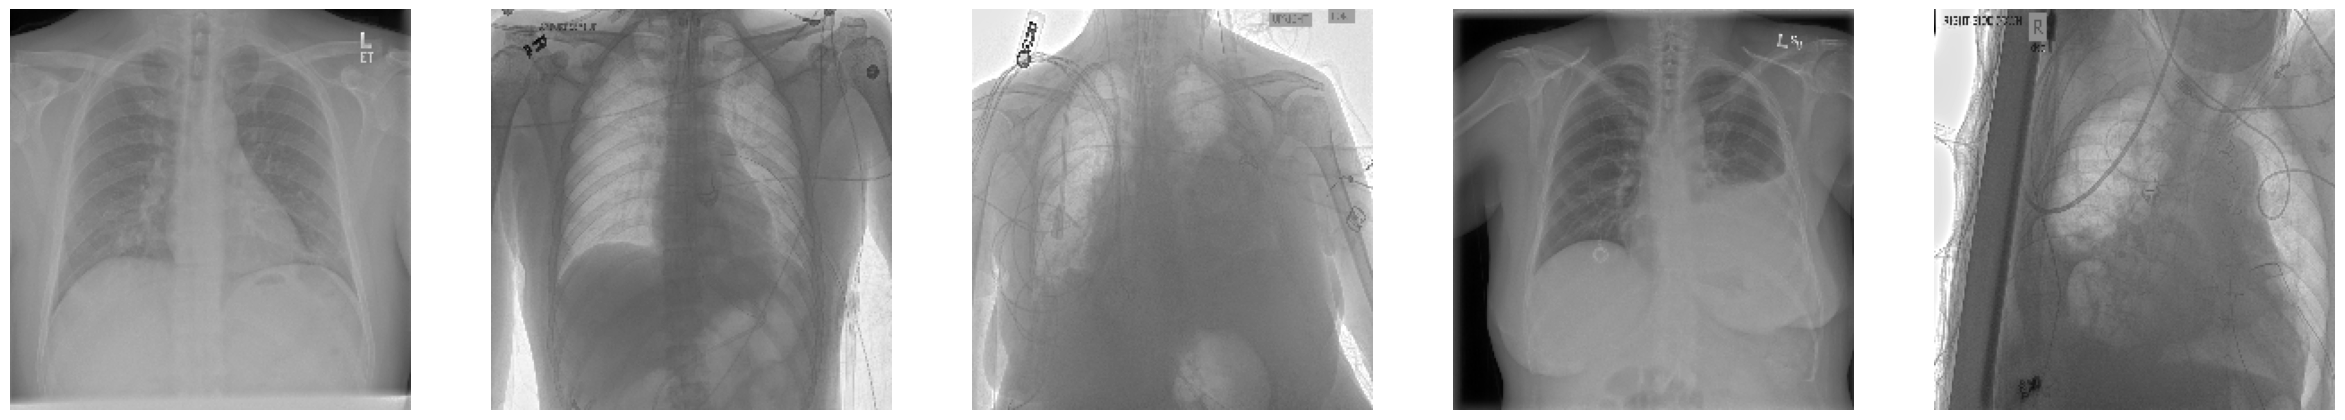

In [9]:
import matplotlib.pyplot as plt
import random
import numpy as np

def plot_random_images(image_list, num_images=5):
    fig, axs = plt.subplots(1, num_images, figsize=(30, 30))
    
    for i in range(num_images):
        img = random.choice(image_list)
        
        # Convert to NumPy array if img is not already one
        if not isinstance(img, np.ndarray):
            img = np.array(img)
        
        # Check if the image has an extra channel dimension (1, 224, 224)
        if img.shape[0] == 1:
            img = img.squeeze(0)  # Remove channel dimension if it exists
        
        if num_images == 1:
            axs.imshow(img, cmap='gray')  # Assuming images are grayscale
            axs.axis('off')
        else:
            axs[i].imshow(img, cmap='gray')  # Assuming images are grayscale
            axs[i].axis('off')
    
    plt.show()

# Example usage: plot 5 random images
plot_random_images(preprocessed_images, num_images=5)

In [7]:
# Initialize a dictionary to hold the count of each disease for the balanced dataset
balanced_disease_count = {disease: 0 for disease in diseases}

# Count the number of samples for each disease in the balanced dataset
for label in image_labels:
    for i, value in enumerate(label):
        if value == 1.0:  # If the disease is present
            balanced_disease_count[diseases[i]] += 1

# Calculate the total samples in the balanced dataset
balanced_total_samples = sum(balanced_disease_count.values())
print("total sample:- ",balanced_total_samples)
# Print the result with counts and percentages for the balanced dataset
print("Counts and percentages for the balanced dataset:")
for disease, count in balanced_disease_count.items():
    percentage = (count / balanced_total_samples) * 100 if balanced_total_samples > 0 else 0
    print(f"{disease}: {count} samples ({percentage:.2f}%)")

total sample:-  77857
Counts and percentages for the balanced dataset:
Enlarged Cardiomediastinum: 3028 samples (3.89%)
Cardiomegaly: 5669 samples (7.28%)
Lung Opacity: 12703 samples (16.32%)
Lung Lesion: 2630 samples (3.38%)
Edema: 6498 samples (8.35%)
Consolidation: 3816 samples (4.90%)
Pneumonia: 2116 samples (2.72%)
Atelectasis: 4367 samples (5.61%)
Pneumothorax: 3567 samples (4.58%)
Pleural Effusion: 12101 samples (15.54%)
Pleural Other: 2040 samples (2.62%)
Fracture: 2799 samples (3.60%)
Support Devices: 14725 samples (18.91%)
No Finding: 1798 samples (2.31%)


Shape: (1, 224, 224), Min: 7.149019607843138, Max: 15.992156862745098


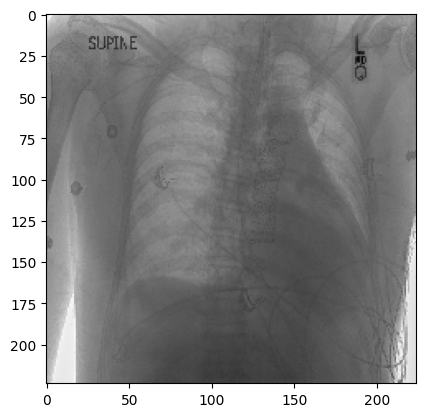

In [14]:
import matplotlib.pyplot as plt

# Choose an image from preprocessed_images
sample_image = preprocessed_images[7000]  # Pick one image for inspection

# Check if image is already in expected shape and range
print(f"Shape: {sample_image.shape}, Min: {sample_image.min()}, Max: {sample_image.max()}")

# Display the image
if sample_image.shape == (224, 224):  # Grayscale image
    plt.imshow(sample_image, cmap='gray')
elif sample_image.shape == (1, 224, 224):  # Grayscale with a single channel
    plt.imshow(sample_image.squeeze(0), cmap='gray')
else:
    raise ValueError(f"Unexpected shape: {sample_image.shape}")

plt.show()

In [8]:
from torchvision import transforms
from PIL import Image
import torch
import numpy as np
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

# Split data
train_images, val_images, train_labels, val_labels = train_test_split(
    preprocessed_images,
    image_labels,
    test_size=0.2, 
    random_state=42
)

In [9]:


train_transforms = transforms.Compose([
    #transforms.Resize((384, 384)),
    #transforms.ToTensor(),  # Convert to tensor after augmentation
    #transforms.RandomAffine(degrees=(-5, 5), scale=(0.9, 1.1)),
    #transforms.RandomResizedCrop((224, 224)),
    #transforms.Normalize((0.49,), (0.248,))  # Normalize with mean and std for grayscale
])

val_transforms = transforms.Compose([
    #transforms.Resize((384, 384)),
    #transforms.ToTensor(),  # Convert to tensor after augmentation
    #transforms.Resize((224, 224)),  # Resize to maintain consistency
    #transforms.Normalize((0.49,), (0.248,))  # Normalize with mean and std for grayscale
])



In [10]:
class MedicalImageDataset(Dataset):
    def __init__(self, images, labels, impressions=None, transform=None):
        self.images = images  # List of preprocessed images
        self.labels = labels  # List of corresponding labels
        self.impressions = impressions  # List of impressions (optional)
        self.transform = transform  # Data augmentation transform (optional)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Fetch the image, label, and impression
        image = self.images[idx]
        label = self.labels[idx]
        impression = self.impressions[idx] if self.impressions is not None else ""  # Ensure impression is always a string

        # Convert the image to RGB if it's in grayscale
        if isinstance(image, np.ndarray):
            # Ensure the image is in the expected shape (grayscale with 224x224 resolution)
            if image.shape == (224, 224):  # Grayscale image
                # Convert grayscale to RGB by stacking the image along the channel dimension
                image = np.stack([image] * 3, axis=-1)  # Shape becomes (224, 224, 3)
            elif image.shape == (1, 224, 224):  # Single-channel grayscale
                image = np.stack([image.squeeze(0)] * 3, axis=-1)  # Convert (1, 224, 224) to (224, 224, 3)
            else:
                raise ValueError(f"Unexpected image shape: {image.shape}")

            # Scale the image values to 0-255 for uint8 conversion
            image = (image - image.min()) / (image.max() - image.min()) * 255
            image = np.clip(image, 0, 255).astype(np.uint8)  # Ensure values are in [0, 255]
            # Convert the NumPy array to a PIL image
            image = Image.fromarray(image)

        # Apply transformations (e.g., normalization, augmentation) if provided
        if self.transform:
            image = self.transform(image)  # This will convert the image to a tensor (C, H, W)

        # Convert label to tensor
        label_tensor = torch.tensor(label, dtype=torch.float32)

        # Return image, label, and impression (always as a string)
        return image, label_tensor

In [11]:
from torch.utils.data import DataLoader
train_dataset = MedicalImageDataset(train_images, train_labels,transform=train_transforms)
val_dataset = MedicalImageDataset(val_images, val_labels,transform=val_transforms)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

# Model Architecture

# VIT MODEL

In [12]:
from transformers import ViTForImageClassification
import torch.nn as nn
import torch

class ViTForImageEmbeddingClassification(ViTForImageClassification):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Enable multi-label classification
        self.config.problem_type = "multi_label_classification"
        # Customize the classifier for 14 output classes (for your case)
        self.classifier = nn.Linear(self.config.hidden_size, 14)
        
    def forward(self, pixel_values, labels=None, return_embeddings=True, return_attentions=True):
        # Forward pass through the Vision Transformer with attention maps and hidden states enabled
        outputs = self.vit(
            pixel_values,
            output_hidden_states=True,
            output_attentions=True
        )
        
        # Extract logits for classification from the [CLS] token
        logits = self.classifier(outputs.last_hidden_state[:, 0, :])

        # Optionally retrieve embeddings from the last hidden state
        embeddings = outputs.hidden_states[-1] if return_embeddings else None
        
        # Optionally retrieve attention maps
        attentions = outputs.attentions if return_attentions else None
        # Calculate the loss if labels are provided (multi-label classification)
        loss = None
        if labels is not None:
            pos_weights_tensor = torch.ones(14)  # Adjust pos_weight tensor as needed
            loss_fct = nn.BCEWithLogitsLoss(pos_weight=pos_weights_tensor)
            loss = loss_fct(logits, labels)

        # Return dictionary with logits, loss, attentions, and embeddings
        return {
            'logits': logits, 
            'loss': loss, 
            'attentions': attentions,
            'imgemb': embeddings
        }

In [13]:
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
import torch.nn as nn
# Load the pre-trained model and adjust the classifier for 14 classes (multi-label classification)
# model = ViTForImageEmbeddingClassification.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTForImageEmbeddingClassification.from_pretrained('google/vit-base-patch16-224-in21k', attn_implementation='eager')
# Move the model to GPU
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)  # Multi-GPU support
model.to(device)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageEmbeddingClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DataParallel(
  (module): ViTForImageEmbeddingClassification(
    (vit): ViTModel(
      (embeddings): ViTEmbeddings(
        (patch_embeddings): ViTPatchEmbeddings(
          (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): ViTEncoder(
        (layer): ModuleList(
          (0-11): 12 x ViTLayer(
            (attention): ViTAttention(
              (attention): ViTSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (output): ViTSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
            )
     

In [14]:
# Initialize the model architecture (this should match the model you saved)
model = ViTForImageEmbeddingClassification.from_pretrained('google/vit-base-patch16-224-in21k', attn_implementation='eager')
model.config.problem_type = "multi_label_classification"
model.classifier = nn.Linear(model.config.hidden_size, 14)
# Modify the configuration
model.patch_size = 8
model.num_hidden_layers = 24
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)  # Multi-GPU support
model.to(device)
# # Load the saved state_dict into the model
# model.load_state_dict(torch.load('/kaggle/working/vit_pretrained_model_v2_final.pth'),strict=False)
# model = nn.DataParallel(model)
# # Move the model to the desired device (GPU or CPU)
# model.to(device)

# print("Model loaded successfully.")

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageEmbeddingClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DataParallel(
  (module): ViTForImageEmbeddingClassification(
    (vit): ViTModel(
      (embeddings): ViTEmbeddings(
        (patch_embeddings): ViTPatchEmbeddings(
          (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): ViTEncoder(
        (layer): ModuleList(
          (0-11): 12 x ViTLayer(
            (attention): ViTAttention(
              (attention): ViTSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (output): ViTSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
            )
     

In [ ]:
model = torch.load('/kaggle/working/vit_entire_pretrained_model_v2_final.pth')
# model = nn.DataParallel(model)
# Move the model to the desired device (GPU or CPU)
model.to(device)

In [ ]:
model.module.save_pretrained('/kaggle/working/vitmodel')

In [15]:
pos_weights = []

# Calculate pos_weight for each disease
for disease, count in balanced_disease_count.items():
    # pos_weight = (num_neg_samples / num_pos_samples)
    if count > 0:
        pos_weight = (balanced_total_samples - count) / count
    else:
        pos_weight = 0.0  # In case no positive samples for a disease
    pos_weights.append(pos_weight)

# Convert the pos_weights list into a tensor
pos_weights_tensor = torch.tensor(pos_weights, dtype=torch.float).to(device)

# Now use this in BCEWithLogitsLoss
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights_tensor)

# Trainig The base Model 


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

Training Epoch 1: 100%|██████████| 310/310 [02:55<00:00,  1.76it/s, Loss=1.77, Accuracy=30.05%]


Epoch 1/20, Loss: 1.7698, Accuracy: 30.05%, Validation Loss: 1.4558, Validation Accuracy: 41.96%


Training Epoch 2: 100%|██████████| 310/310 [02:55<00:00,  1.77it/s, Loss=1.23, Accuracy=55.54%]


Epoch 2/20, Loss: 1.2285, Accuracy: 55.54%, Validation Loss: 1.2006, Validation Accuracy: 65.26%


Training Epoch 3: 100%|██████████| 310/310 [02:54<00:00,  1.78it/s, Loss=0.926, Accuracy=72.85%]


Epoch 3/20, Loss: 0.9258, Accuracy: 72.85%, Validation Loss: 0.8366, Validation Accuracy: 78.30%


Training Epoch 4: 100%|██████████| 310/310 [02:54<00:00,  1.77it/s, Loss=0.713, Accuracy=82.82%]


Epoch 4/20, Loss: 0.7132, Accuracy: 82.82%, Validation Loss: 0.6846, Validation Accuracy: 84.58%


Training Epoch 5: 100%|██████████| 310/310 [02:54<00:00,  1.77it/s, Loss=0.551, Accuracy=90.17%]


Epoch 5/20, Loss: 0.5511, Accuracy: 90.17%, Validation Loss: 0.5717, Validation Accuracy: 90.39%


Training Epoch 6: 100%|██████████| 310/310 [02:56<00:00,  1.76it/s, Loss=0.435, Accuracy=93.95%]


Epoch 6/20, Loss: 0.4347, Accuracy: 93.95%, Validation Loss: 0.4909, Validation Accuracy: 94.00%


Training Epoch 7: 100%|██████████| 310/310 [02:55<00:00,  1.77it/s, Loss=0.345, Accuracy=96.21%]


Epoch 7/20, Loss: 0.3446, Accuracy: 96.21%, Validation Loss: 0.4277, Validation Accuracy: 95.87%


Training Epoch 8: 100%|██████████| 310/310 [02:56<00:00,  1.75it/s, Loss=0.274, Accuracy=97.86%]


Epoch 8/20, Loss: 0.2742, Accuracy: 97.86%, Validation Loss: 0.4213, Validation Accuracy: 97.13%


Training Epoch 9: 100%|██████████| 310/310 [02:54<00:00,  1.77it/s, Loss=0.289, Accuracy=96.77%]


Epoch 9/20, Loss: 0.2891, Accuracy: 96.77%, Validation Loss: 0.3667, Validation Accuracy: 97.05%


Training Epoch 10: 100%|██████████| 310/310 [02:55<00:00,  1.77it/s, Loss=0.202, Accuracy=98.93%]


Epoch 10/20, Loss: 0.2020, Accuracy: 98.93%, Validation Loss: 0.3272, Validation Accuracy: 98.42%


Training Epoch 11: 100%|██████████| 310/310 [02:55<00:00,  1.77it/s, Loss=0.149, Accuracy=99.78%]


Epoch 11/20, Loss: 0.1491, Accuracy: 99.78%, Validation Loss: 0.3054, Validation Accuracy: 98.85%


Training Epoch 12: 100%|██████████| 310/310 [02:54<00:00,  1.78it/s, Loss=0.121, Accuracy=99.92%]


Epoch 12/20, Loss: 0.1210, Accuracy: 99.92%, Validation Loss: 0.2945, Validation Accuracy: 98.98%


Training Epoch 13: 100%|██████████| 310/310 [02:56<00:00,  1.76it/s, Loss=0.101, Accuracy=99.95%]


Epoch 13/20, Loss: 0.1007, Accuracy: 99.95%, Validation Loss: 0.2986, Validation Accuracy: 99.00%


Training Epoch 14: 100%|██████████| 310/310 [02:54<00:00,  1.77it/s, Loss=0.13, Accuracy=99.04%]  


Epoch 14/20, Loss: 0.1303, Accuracy: 99.04%, Validation Loss: 0.2874, Validation Accuracy: 98.39%


Training Epoch 15: 100%|██████████| 310/310 [02:55<00:00,  1.77it/s, Loss=0.0739, Accuracy=99.94%]


Epoch 15/20, Loss: 0.0739, Accuracy: 99.94%, Validation Loss: 0.2801, Validation Accuracy: 98.98%


Training Epoch 16: 100%|██████████| 310/310 [02:53<00:00,  1.79it/s, Loss=0.0585, Accuracy=99.99%]


Epoch 16/20, Loss: 0.0585, Accuracy: 99.99%, Validation Loss: 0.3018, Validation Accuracy: 98.98%


Training Epoch 17: 100%|██████████| 310/310 [02:54<00:00,  1.77it/s, Loss=0.0485, Accuracy=99.99%] 


Epoch 17/20, Loss: 0.0485, Accuracy: 99.99%, Validation Loss: 0.2628, Validation Accuracy: 99.11%


Training Epoch 18: 100%|██████████| 310/310 [02:53<00:00,  1.78it/s, Loss=0.0404, Accuracy=100.00%]


Epoch 18/20, Loss: 0.0404, Accuracy: 100.00%, Validation Loss: 0.2985, Validation Accuracy: 99.08%


Training Epoch 19: 100%|██████████| 310/310 [02:53<00:00,  1.79it/s, Loss=0.0735, Accuracy=99.30%] 


Epoch 19/20, Loss: 0.0735, Accuracy: 99.30%, Validation Loss: 0.3468, Validation Accuracy: 96.01%
Early stopping triggered.
Training Complete


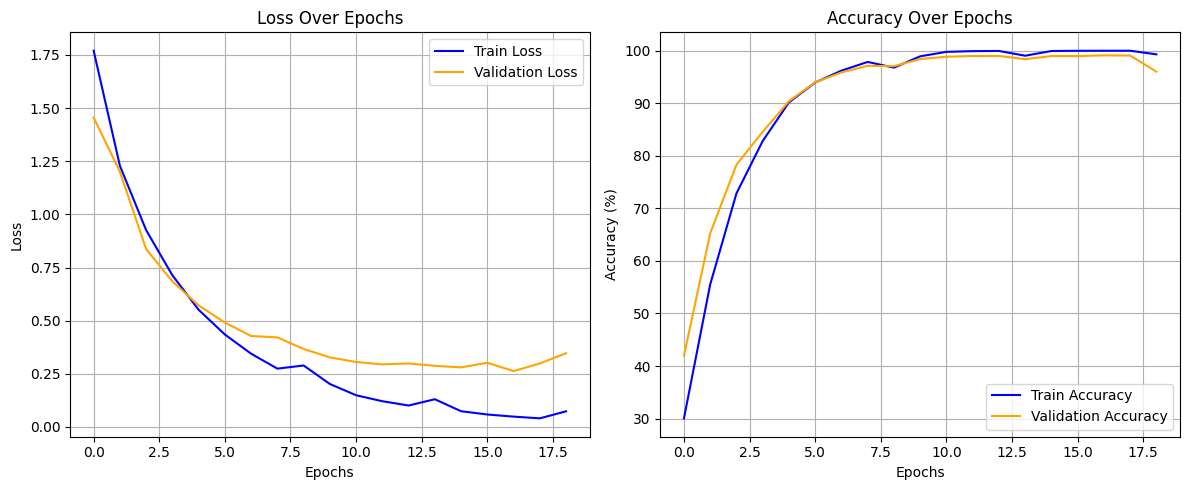

Training results saved to 'training_results.pkl'.


In [17]:
from torch.utils.data import DataLoader
from transformers import ViTFeatureExtractor
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import AdamW 
import torch.nn as nn
from PIL import Image
import numpy as np
from tqdm import tqdm  # Import tqdm for progress bar

# Initialize lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Load the feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

# Define the optimizer
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, min_lr=1e-7, verbose=True)

# Adjust the feature extractor to handle RGB images
feature_extractor = ViTFeatureExtractor(
    do_resize=False, 
    size=224, 
    do_rescale=False,  # Disable rescaling if your images are already in the [0, 1] range
    do_normalize=True, 
    image_mean=[0.485, 0.456, 0.406], 
    image_std=[0.229, 0.224, 0.225],  # Use 3-channel std for RGB
    resample=Image.BILINEAR
)

# Early Stopping Parameters
patience = 2  # Number of epochs to wait for improvement before stopping
best_val_loss = float('inf')
epochs_without_improvement = 0

num_epochs = 20

# Create a GradScaler for mixed precision
scaler = torch.cuda.amp.GradScaler()

# Updated training loop with early stopping and progress bar updates
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    train_progress_bar = tqdm(train_dataloader, desc=f"Training Epoch {epoch + 1}", leave=True)

    for batch_idx, batch in enumerate(train_progress_bar):
        images, labels = batch
        
        inputs = feature_extractor(images=images, return_tensors="pt").to(device)
        labels = labels.to(device)

        # Mixed precision context
        with torch.cuda.amp.autocast():
            # Forward pass
            outputs = model(**inputs)  # Get the outputs as a dictionary
            logits = outputs['logits']  # Extract logits
            attn = outputs['attentions']
            img_emb=outputs['imgemb']

            # Compute the loss
            loss = criterion(logits, labels)

        # Backward pass and optimization
        scaler.scale(loss).backward()  # Scale the loss for gradient scaling
        scaler.step(optimizer)  # Step the optimizer
        scaler.update()  # Update the scaler
        optimizer.zero_grad()  # Zero the gradients

        running_loss += loss.item()
        
        # Calculate accuracy
        preds = torch.sigmoid(logits)  # Apply sigmoid to get probabilities
        predicted_labels = (preds > 0.5).float()
        correct_predictions += (predicted_labels == labels).sum().item()
        total_samples += labels.numel()

        # Update the progress bar with current loss and accuracy
        accuracy = correct_predictions / total_samples * 100
        avg_loss = running_loss / (batch_idx + 1)
        train_progress_bar.set_postfix({"Loss": avg_loss, "Accuracy": f"{accuracy:.2f}%"})

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_samples = 0
    with torch.no_grad():
        for batch in val_dataloader:
            images, labels = batch

            inputs = feature_extractor(images=images, return_tensors="pt").to(device)
            labels = labels.to(device)

            with torch.cuda.amp.autocast():
                outputs = model(**inputs)  # Get the outputs as a dictionary
                logits = outputs['logits']  # Extract logits
                attn = outputs['attentions']  # Extract embeddings if needed
                img_emb=outputs['imgemb']
                loss = criterion(logits, labels)

            val_loss += loss.item()

            preds = torch.sigmoid(logits)
            predicted_labels = (preds > 0.5).float()
            correct_val_predictions += (predicted_labels == labels).sum().item()
            total_val_samples += labels.numel()

    avg_val_loss = val_loss / len(val_dataloader)
    val_accuracy = correct_val_predictions / total_val_samples * 100
    train_losses.append(avg_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(accuracy)
    val_accuracies.append(val_accuracy)
    scheduler.step(avg_val_loss)
    # Print validation metrics
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%, "
          f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # Early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        # Optionally, save the model checkpoint here
        # torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print("Early stopping triggered.")
            break

print("Training Complete")
import matplotlib.pyplot as plt
# Plot the metrics
plt.figure(figsize=(12, 5))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()
import pickle

# Save the lists to a file using pickle
data_to_save = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies,
}

with open('/kaggle/working/base_model_training_results.pkl', 'wb') as f:
    pickle.dump(data_to_save, f)

print("Training results saved to 'training_results.pkl'.")

In [19]:
import torch

# Define the path where you want to save the model
save_path = '/kaggle/working/vit_pretrained_model_v2_final.pth'

# Save the model's state_dict (recommended method)
torch.save(model.state_dict(), save_path)

print(f"Model saved to {save_path}")

Model saved to /kaggle/working/vit_pretrained_model_v2_final.pth


In [ ]:
# Initialize the model architecture (this should match the model you saved)
model = YourModelClass(*args)

# Load the saved state_dict into the model
model.load_state_dict(torch.load(save_path))

# Move the model to the desired device (GPU or CPU)
model.to(device)

print("Model loaded successfully.")

In [20]:
# Save the entire model (not just the state_dict)
torch.save(model, '/kaggle/working/vit_entire_pretrained_model_v2_final.pth')


# Visualization of attention map 

In [21]:
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
from transformers import ViTForImageClassification, ViTImageProcessor
from PIL import Image
import torch
import numpy as np

# Function to load and process DICOM image
def load_dicom_image(image_path):
    dicom_data = pydicom.dcmread(image_path)

    # Apply the VOI LUT (Value of Interest Look Up Table) if present, to enhance the image for viewing
    image = apply_voi_lut(dicom_data.pixel_array, dicom_data)
    
    # If the image is monochrome (grayscale), convert it to RGB by stacking the grayscale channels
    if len(image.shape) == 2:  # Grayscale image
        image = np.stack([image] * 3, axis=-1)  # Convert grayscale to RGB
    
    # Normalize pixel values to [0, 255] and convert to uint8
    image = (image - np.min(image)) / (np.max(image) - np.min(image)) * 255
    image = image.astype(np.uint8)
    
    # Convert the NumPy array to a PIL image
    return Image.fromarray(image)

# Load a pre-trained ViT model and processor
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k', do_rescale=False)
# model = ViTForImageClassification.from_pretrained(model_name, attn_implementation='eager')
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Load the pre-trained model and adjust the classifier for 14 classes (multi-label classification)
model = ViTForImageEmbeddingClassification.from_pretrained('/kaggle/working/vitmodel', attn_implementation='eager')
# Move the model to GPU
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)  # Multi-GPU support
model.to(device)
# Load DICOM image from file path
dicom_image_path = "/kaggle/input/nlp-data/train/patient01122/study1/view1_frontal.dcm"  # Replace with your DICOM image path
image = load_dicom_image(dicom_image_path)

# Preprocess the image and prepare for model input
inputs = processor(images=image, return_tensors="pt")

# Make sure model and inputs are on the same device (e.g., GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = {k: v.to(device) for k, v in inputs.items()}

# Run the image through the model
outputs = model(**inputs)

# Getting the attentions
attentions = outputs['attentions']  # Access the attention maps

# # Print or visualize the attentions as needed
# print("Attention maps extracted:", attentions)

In [ ]:
len(attentions)

In [22]:
def attention_rollout(attentions):
    # Initialize rollout with identity matrix
    rollout = torch.eye(attentions[0].size(-1)).to(attentions[0].device)

    # Multiply attention maps layer by layer
    for attention in attentions:
        attention_heads_fused = attention.mean(dim=1) # Average attention across heads
        attention_heads_fused += torch.eye(attention_heads_fused.size(-1)).to(attention_heads_fused.device) # A + I
        attention_heads_fused /= attention_heads_fused.sum(dim=-1, keepdim=True) # Normalizing A
        rollout = torch.matmul(rollout, attention_heads_fused) # Multiplication

    return rollout

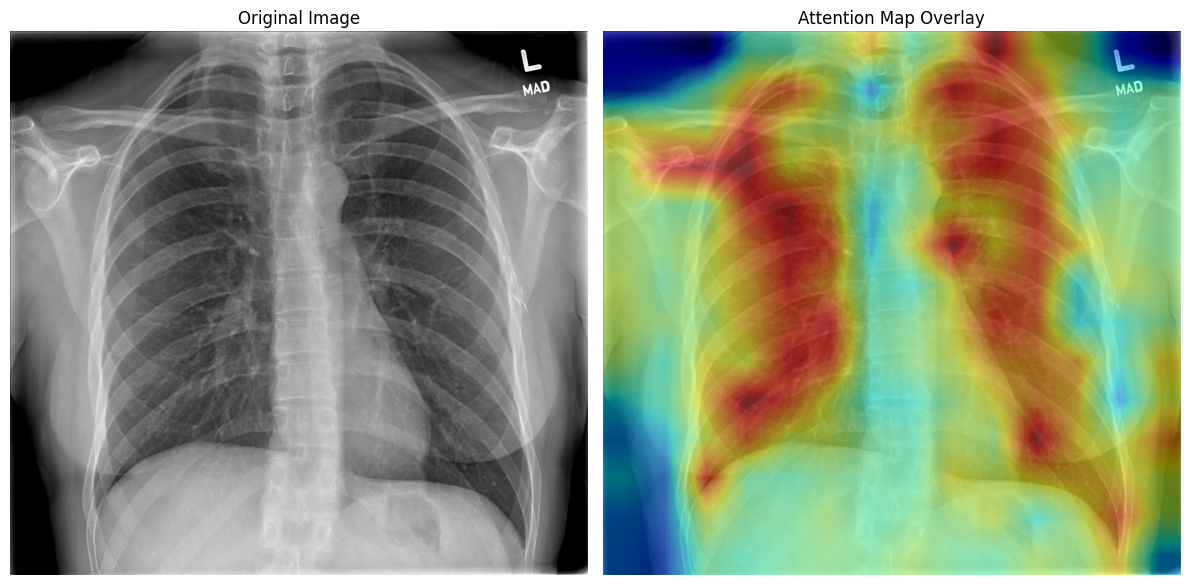

In [23]:
import matplotlib.pyplot as plt
import torchvision.transforms as T

def visualize_attention(image, attention_map):
    # Resize the attention map to the size of the original image
    attention_map_resized = T.Resize((image.size[1], image.size[0]))(Image.fromarray(attention_map))

    # Convert to numpy arrays
    image_np = np.array(image)
    attention_map_resized_np = np.array(attention_map_resized)

    # Normalize the attention map between 0 and 1 for visualization
    attention_map_resized_np = (attention_map_resized_np - np.min(attention_map_resized_np)) / \
                                (np.max(attention_map_resized_np) - np.min(attention_map_resized_np))

    # Create a heatmap and overlay it on the original image
    plt.figure(figsize=(12, 6))  # Adjust figure size as needed

    # Plot the original image
    plt.subplot(1, 2, 1)
    plt.imshow(image_np)
    plt.title("Original Image")
    plt.axis('off')  # Turn off axis labels

    # Plot the attention overlay
    plt.subplot(1, 2, 2)
    plt.imshow(image_np)
    plt.imshow(attention_map_resized_np, cmap='jet', alpha=0.5)  # alpha controls transparency of heatmap
    plt.title("Attention Map Overlay")
    plt.axis('off')  # Turn off axis labels

    plt.tight_layout()  # Adjust layout for better spacing
    plt.show()

# Call the function to visualize the attention map on the DICOM image
rollout = attention_rollout(attentions)
cls_attention = rollout[0, 1:, 0]  # Get attention values from [CLS] token to all patches
num_of_patches = cls_attention.size(0)
cls_attention = 1 - cls_attention.reshape(int(np.sqrt(num_of_patches)), int(np.sqrt(num_of_patches)))

# Convert the attention to numpy format
cls_attention_np = cls_attention.cpu().detach().numpy()

# Visualize the attention map on the DICOM image
visualize_attention(image, cls_attention_np)


# attention patches

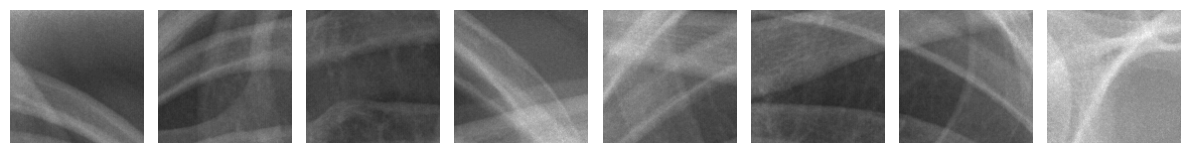

There are 27 additional patches not displayed.


In [24]:
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt

def extract_high_attention_red_patches(image, attention_map, high_threshold=0.7):
    """
    Extract patches from high-attention (red) regions based on a specific threshold.
    
    Parameters:
    - image: PIL Image from which patches are to be extracted.
    - attention_map: 2D numpy array with attention values normalized between 0 and 1.
    - high_threshold: Threshold value for filtering high-attention (red) areas.

    Returns:
    - patches: List of PIL image patches from high-attention areas.
    """
    # Normalize attention map to [0, 1]
    attention_map = (attention_map - np.min(attention_map)) / (np.max(attention_map) - np.min(attention_map))

    # Determine the patch size based on the attention map's granularity
    num_patches_per_side = attention_map.shape[0]
    patch_size = image.size[0] // num_patches_per_side  # Assuming square patches
    patches = []
    positions = []  # To store positions
    # Create a binary mask for high-attention regions (red areas)
    high_attention_mask = attention_map >= high_threshold

    # Extract patches only where high attention is detected
    for row in range(num_patches_per_side):
        for col in range(num_patches_per_side):
            if high_attention_mask[row, col]:  # Only consider high-attention regions
                # Calculate patch boundaries
                left = col * patch_size
                upper = row * patch_size
                right = left + patch_size
                lower = upper + patch_size

                # Ensure patch is within image bounds
                if right <= image.size[0] and lower <= image.size[1]:
                    # Extract the patch and add it to the list
                    patch = image.crop((left, upper, right, lower))
                    patches.append(patch)
                    positions.append((left, upper))

    return patches,positions

# Reshape cls_attention_np back to match the structure of patches
num_of_patches = int(np.sqrt(cls_attention_np.size))
cls_attention_reshaped = cls_attention_np.reshape((num_of_patches, num_of_patches))

# Extract patches from high-attention areas with a dynamically adjustable threshold
high_attention_patches,position = extract_high_attention_red_patches(image, cls_attention_reshaped, high_threshold=0.8)

# Visualization function for extracted patches
def visualize_extracted_patches(patches, max_display=5):
    plt.figure(figsize=(12, 6))
    
    # Determine how many patches to display
    num_patches = len(patches)
    patches_to_display = patches[:max_display]  # Get the first few patches to display
    
    # Visualize the selected patches
    for i, patch in enumerate(patches_to_display):
        plt.subplot(1, max_display, i + 1)
        plt.imshow(patch)
        plt.axis('off')
    
    plt.tight_layout()  # Adjust layout
    plt.show()
    
    # Print the number of remaining patches
    if num_patches > max_display:
        print(f"There are {num_patches - max_display} additional patches not displayed.")

# Call the function to visualize extracted high-attention patches
visualize_extracted_patches(high_attention_patches, max_display=8)

# Super Resolution Model 

In [25]:
!pip install git+https://github.com/huggingface/diffusers.git

  Cloning https://github.com/huggingface/diffusers.git to /tmp/pip-req-build-lpv3it82
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers.git /tmp/pip-req-build-lpv3it82
  Resolved https://github.com/huggingface/diffusers.git to commit 76b7d86a9a5c0c2186efa09c4a67b5f5666ac9e3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for diffusers: filename=diffusers-0.32.0.dev0-py3-none-any.whl size=2926416 sha256=ab1435b78a104a4db4781f00b695766b7034dce3f292b92eb60f7f3de0abc289
  Stored in directory: /tmp/pip-ephem-wheel-cache-ag5xi3e6/wheels/4d/b7/a8/6f9549ceec5daad78675b857ac57d697c387062506520a7b50
Successfully built diffusers


In [26]:


import requests
from PIL import Image
from io import BytesIO
from diffusers import LDMSuperResolutionPipeline
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model_id = "CompVis/ldm-super-resolution-4x-openimages"

# load model and scheduler
pipeline = LDMSuperResolutionPipeline.from_pretrained(model_id)
pipeline = pipeline.to(device)

# # let's download an  image
# url = "https://user-images.githubusercontent.com/38061659/199705896-b48e17b8-b231-47cd-a270-4ffa5a93fa3e.png"
# response = requests.get(url)
# low_res_img = Image.open(BytesIO(response.content)).convert("RGB")
# low_res_img = low_res_img.resize((128, 128))

# # run pipeline in inference (sample random noise and denoise)
# upscaled_image = pipeline(low_res_img, num_inference_steps=100, eta=1).images[0]
# # save image
# upscaled_image.save("/kaggle/working/ldm_generated_image.png")


model_index.json:   0%|          | 0.00/248 [00:00<?, ?B/s]

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/455M [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

vqvae/config.json:   0%|          | 0.00/713 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/873 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/221M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--CompVis--ldm-super-resolution-4x-openimages/snapshots/0b55ddf931a8e3a1b426b3a50ddcf325ff84f668/vqvae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--CompVis--ldm-super-resolution-4x-openimages/snapshots/0b55ddf931a8e3a1b426b3a50ddcf325ff84f668/vqvae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--CompVis--ldm-super-resolution-4x-openimages/snapshots/0b55ddf931a8e3a1b426b3a50ddcf325ff84f668/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--CompVis--ldm-super-resolution-4x-openimages/snapshots/0b55ddf931a8e3a1b426b3a50ddcf325ff84f668/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


# Super resolution on the patches 

In [28]:
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt
from diffusers import LDMSuperResolutionPipeline

# Load the LDM Super-Resolution model
device = "cuda" if torch.cuda.is_available() else "cpu"
model_id = "CompVis/ldm-super-resolution-4x-openimages"
pipeline = LDMSuperResolutionPipeline.from_pretrained(model_id)
pipeline = pipeline.to(device)

def apply_super_resolution_to_patches(patches, sr_model):
    """
    Apply super-resolution to each patch.

    Parameters:
    - patches: List of PIL image patches.
    - sr_model: Pre-trained super-resolution model pipeline.

    Returns:
    - List of super-resolved patches.
    """
    sr_patches = []
    for patch in patches:
        with torch.no_grad():
            sr_patch = sr_model(patch, num_inference_steps=100, eta=1).images[0]
        sr_patches.append(sr_patch)
    return sr_patches

def reinsert_super_resolved_patches(original_image, sr_patches, positions, patch_size):
    """
    Reinsert super-resolved patches into their original positions in the original image.
    
    Parameters:
    - original_image: The full PIL image (for context).
    - sr_patches: List of super-resolved patches as PIL images.
    - positions: List of tuples indicating the top-left coordinates of each patch.
    - patch_size: Size of each patch (width, height).

    Returns:
    - PIL Image with super-resolved patches reinserted.
    """
    sr_image = original_image.copy()

    # Insert each super-resolved patch back into the original image
    for sr_patch, (left, upper) in zip(sr_patches, positions):
        # Resize super-resolved patch to match the original patch size
        sr_patch_resized = sr_patch.resize(patch_size, Image.BICUBIC)

        # Insert the patch into the original image
        sr_image.paste(sr_patch_resized, (left, upper))

    return sr_image

# Example usage
# Assuming `cls_attention_np` and `image` are already defined

num_of_patches = int(np.sqrt(cls_attention_np.size))
cls_attention_reshaped = cls_attention_np.reshape((num_of_patches, num_of_patches))

# Extract patches and their positions
high_attention_patches, patch_positions = extract_high_attention_red_patches(image, cls_attention_reshaped, high_threshold=0.8)

# Determine the patch size (assuming square patches)
patch_size = (high_attention_patches[0].size[0], high_attention_patches[0].size[1])

# Apply super-resolution to the high-attention patches
super_resolved_patches = apply_super_resolution_to_patches(high_attention_patches, pipeline)

# Reinsert super-resolved patches back into the original image using stored positions
final_image_with_sr_patches = reinsert_super_resolved_patches(image, super_resolved_patches, patch_positions, patch_size)



Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--CompVis--ldm-super-resolution-4x-openimages/snapshots/0b55ddf931a8e3a1b426b3a50ddcf325ff84f668/vqvae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--CompVis--ldm-super-resolution-4x-openimages/snapshots/0b55ddf931a8e3a1b426b3a50ddcf325ff84f668/vqvae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--CompVis--ldm-super-resolution-4x-openimages/snapshots/0b55ddf931a8e3a1b426b3a50ddcf325ff84f668/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--CompVis--ldm-super-resolution-4x-openimages/snapshots/0b55ddf931a8e3a1b426b3a50ddcf325ff84f668/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

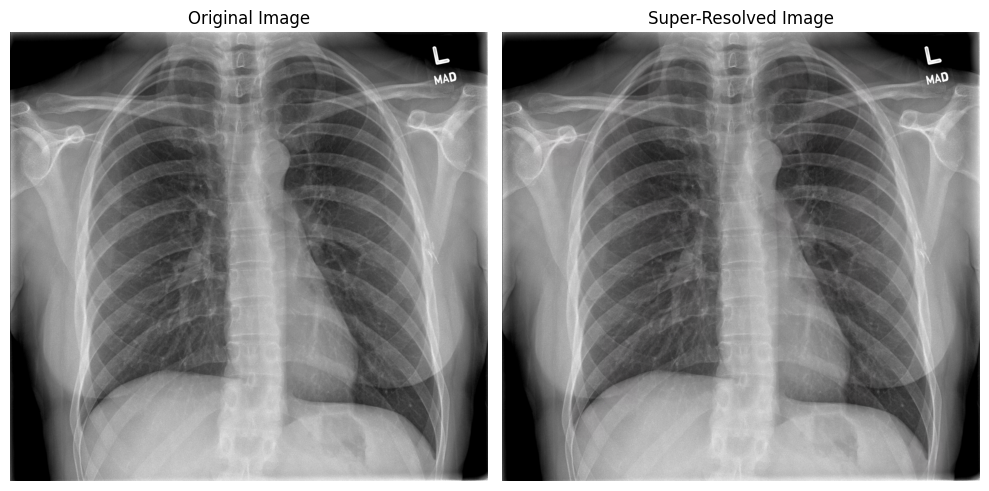

In [29]:
# Plotting the original and the final image using matplotlib
plt.figure(figsize=(10, 5))


plt.subplot(1, 2, 1)
plt.imshow(np.array(image))
plt.title("Original Image")
plt.axis("off")  # Hide axes

plt.subplot(1, 2, 2)
plt.imshow(np.array(final_image_with_sr_patches))
plt.title("Super-Resolved Image")
plt.axis("off")  # Hide axes

plt.tight_layout()
plt.show()

In [31]:
import numpy as np
from skimage import metrics
original_image=image
# Convert original and final super-resolved images to NumPy arrays
original_image_np = np.array(original_image)
final_image_with_sr_patches_np = np.array(final_image_with_sr_patches)

# Calculate PSNR for original image (compared with itself)
psnr_original = metrics.peak_signal_noise_ratio(original_image_np, original_image_np)
print(f"PSNR (Original vs Original): {psnr_original:.2f} dB")

# Calculate SSIM for original image (compared with itself)
ssim_original = metrics.structural_similarity(original_image_np, original_image_np, channel_axis=-1, win_size=3)
print(f"SSIM (Original vs Original): {ssim_original:.4f}")

# Calculate PSNR for super-resolved image compared to original image
psnr = metrics.peak_signal_noise_ratio(original_image_np, final_image_with_sr_patches_np)
print(f"PSNR (Original vs Super-Resolved): {psnr:.2f} dB")

# Calculate SSIM for super-resolved image compared to original image
ssim = metrics.structural_similarity(original_image_np, final_image_with_sr_patches_np, channel_axis=-1, win_size=3)
print(f"SSIM (Original vs Super-Resolved): {ssim:.4f}")


PSNR (Original vs Original): inf dB
SSIM (Original vs Original): 1.0000
PSNR (Original vs Super-Resolved): 46.58 dB
SSIM (Original vs Super-Resolved): 0.9879


# SuperResolution on the data.

In [7]:
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
from transformers import ViTForImageClassification, ViTImageProcessor
from PIL import Image
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as T
from diffusers import LDMSuperResolutionPipeline
import torch.nn as nn
import pickle
from tqdm import tqdm
from IPython.display import clear_output
from torch.nn import DataParallel
import random
import cv2
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load ViT model and processor
processor = ViTImageProcessor.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    do_normalize=False
)
model = ViTForImageEmbeddingClassification.from_pretrained('/kaggle/working/vitmodel', attn_implementation='eager').to(device)
model = nn.DataParallel(model)
# Load LDM Super-Resolution model
sr_pipeline = LDMSuperResolutionPipeline.from_pretrained("CompVis/ldm-super-resolution-4x-openimages").to(device)
#sr_pipeline = nn.DataParallel(sr_pipeline)
def load_dicom_image(image_array, target_size=(224, 224)):
    # Apply VOI LUT to adjust pixel intensities if needed
    image = apply_voi_lut(image_array, dicom_data)
    
    # Convert grayscale to RGB if needed
    if len(image.shape) == 2:
        image = np.stack([image] * 3, axis=-1)
    
    # Intensity rescaling to enhance contrast
    image = (image - np.min(image)) / (np.max(image) - np.min(image)) * 255
    image = image.astype(np.uint8)
    
    # Resize the image to target dimensions
#     image = cv2.resize(image, target_size)
    
    # Convert to PIL Image for compatibility with further processing steps
    return Image.fromarray((image * 255).astype(np.uint8))

def attention_rollout(attentions):
    rollout = torch.eye(attentions[0].size(-1)).to(attentions[0].device)
    for attention in attentions:
        attention_heads_fused = attention.mean(dim=1)
        attention_heads_fused += torch.eye(attention_heads_fused.size(-1)).to(attention_heads_fused.device)
        attention_heads_fused /= attention_heads_fused.sum(dim=-1, keepdim=True)
        rollout = torch.matmul(rollout, attention_heads_fused)
    return rollout

def extract_high_attention_red_patches(image, attention_map, high_threshold=0.7):
    # Normalize attention map
    attention_map = (attention_map - np.min(attention_map)) / (np.max(attention_map) - np.min(attention_map))
    num_patches_per_side = attention_map.shape[0]
    
    # Handle image size retrieval based on image type
    if isinstance(image, Image.Image):
        width, height = image.size  # PIL image
    elif isinstance(image, torch.Tensor):
        width, height = image.size(-1), image.size(-2)  # Tensor with shape (C, H, W)
    else:
        raise TypeError("Unsupported image format. Expected PIL Image or torch.Tensor.")

    # Calculate patch size based on the number of patches per side
    patch_size = width // num_patches_per_side

    patches, positions = [], []
    high_attention_mask = attention_map >= high_threshold

    for row in range(num_patches_per_side):
        for col in range(num_patches_per_side):
            if high_attention_mask[row, col]:
                left, upper = col * patch_size, row * patch_size
                right, lower = left + patch_size, upper + patch_size
                if right <= width and lower <= height:
                    # Crop patch based on image type
                    if isinstance(image, Image.Image):
                        patch = image.crop((left, upper, right, lower))
                    elif isinstance(image, torch.Tensor):
                        patch = image[:, upper:lower, left:right]
                    patches.append(patch)
                    positions.append((left, upper))
    print(len(patches))
    return patches, positions

def apply_super_resolution_to_patches(patches, sr_pipeline, num_super_res_patches=5):
    sr_patches = []
    # Randomly select patches to apply super-resolution
    selected_indices = random.sample(range(len(patches)), min(num_super_res_patches, len(patches)))
    for i, patch in enumerate(patches):
        if i in selected_indices:
            with torch.no_grad():
                sr_patch = sr_pipeline(patch, num_inference_steps=25, eta=1).images[0]
        else:
            sr_patch = patch  # Keep original patch if not selected for super-resolution
        sr_patches.append(sr_patch)
    return sr_patches
def visualize_extracted_patches(patches, max_display=5):
    plt.figure(figsize=(12, 6))
    
    # Determine how many patches to display
    num_patches = len(patches)
    patches_to_display = patches[:max_display]  # Get the first few patches to display
    
    # Visualize the selected patches
    for i, patch in enumerate(patches_to_display):
        plt.subplot(1, max_display, i + 1)
        plt.imshow(patch)
        plt.axis('off')
    
    plt.tight_layout()  # Adjust layout
    plt.show()
    
    # Print the number of remaining patches
    if num_patches > max_display:
        print(f"There are {num_patches - max_display} additional patches not displayed.")


def reinsert_super_resolved_patches(original_image, sr_patches, positions, patch_size):
    sr_image = original_image.copy()
    for sr_patch, (left, upper) in zip(sr_patches, positions):
        sr_patch_resized = sr_patch.resize(patch_size, Image.BICUBIC)
        sr_image.paste(sr_patch_resized, (left, upper))
    return sr_image

import pandas as pd
import os
from tqdm import tqdm

# Load the consolidated CSV file
consolidated_csv_path = '/kaggle/input/updated-data/consolidated_data-2.csv'
df = pd.read_csv(consolidated_csv_path)

# Sample records (use the required number as per your dataset)
df_sampled = df.sample(n=12500, random_state=42)

# Lists to store processed data
processed_images = []
processed_labels = []
progress_bar = tqdm(df_sampled.iterrows(), desc="Processing DICOM Images", total=len(df_sampled))
count=0
# Preprocess and process images from the DataFrame
for index, row in progress_bar:
    dcm_path = row['path_to_dcm']
    label_vector = row['finding_labels']

    if os.path.exists(dcm_path):
        try:
            # Load DICOM image
            dicom_data = pydicom.dcmread(dcm_path)
            image_array = dicom_data.pixel_array
            image = load_dicom_image(image_array)
            
            # Process label vector
            if isinstance(label_vector, str):
                label_vector = eval(label_vector)
            label_vector = [0 if val is None or val == -1 else val for val in label_vector]

            # Only process every 20th image
            if index % 50 == 0:
                # Preprocess and get attention
                inputs = processor(images=image, return_tensors="pt").to(device)
                with torch.no_grad():
                    outputs = model(**inputs)
                    attentions = outputs['attentions']
                    rollout = attention_rollout(attentions)
                    cls_attention = rollout[0, 1:, 0]
                    num_patches = int(np.sqrt(cls_attention.size(0)))
                    cls_attention = 1 - cls_attention.reshape(num_patches, num_patches).cpu().numpy()

                # Extract high-attention patches and apply SR
                high_attention_patches, positions = extract_high_attention_red_patches(image, cls_attention, high_threshold=0.8)
                if high_attention_patches:
                    super_resolved_patches = apply_super_resolution_to_patches(high_attention_patches, sr_pipeline, num_super_res_patches=5)
                    patch_size = (high_attention_patches[0].size[0], high_attention_patches[0].size[1])
                    final_image = reinsert_super_resolved_patches(image, super_resolved_patches, positions, patch_size)
                else:
                    final_image = image.resize((224, 224))
                if count>3:
                    clear_output(wait=True)
                    count = 0
                count+=1
            else:
                final_image = image.resize((224, 224))

            processed_images.append(final_image)
            processed_labels.append(np.array(label_vector))

        except Exception as e:
            print(f"Error processing image at {dcm_path}: {e}")
            continue

# Save processed data
processed_data = {
    'images': processed_images,
    'labels': processed_labels
}
with open('super_resolution_data.pkl', 'wb') as f:
    pickle.dump(processed_data, f)

Processing DICOM Images:  99%|█████████▊| 12316/12500 [3:22:08<01:00,  3.05it/s]

77


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Processing DICOM Images: 100%|██████████| 12500/12500 [3:23:31<00:00,  1.02it/s]


In [4]:
import pickle

# Load the processed data
with open('super_resolution_data.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

# Access the images and labels
preprocessed_images = loaded_data['images']
image_labels = loaded_data['labels']


In [2]:
print(len(preprocessed_images))
print(len(image_labels))

12500
12500


# Training the vit model with super resolution image

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

Training Epoch 1: 100%|██████████| 310/310 [02:48<00:00,  1.84it/s, Loss=1.84, Accuracy=25.19%]


Epoch 1/20, Loss: 1.8425, Accuracy: 25.19%, Validation Loss: 1.6978, Validation Accuracy: 33.53%


Training Epoch 2: 100%|██████████| 310/310 [02:50<00:00,  1.82it/s, Loss=1.47, Accuracy=41.05%]


Epoch 2/20, Loss: 1.4725, Accuracy: 41.05%, Validation Loss: 1.2801, Validation Accuracy: 50.57%


Training Epoch 3: 100%|██████████| 310/310 [02:50<00:00,  1.82it/s, Loss=1.11, Accuracy=60.02%]


Epoch 3/20, Loss: 1.1135, Accuracy: 60.02%, Validation Loss: 0.9874, Validation Accuracy: 66.73%


Training Epoch 4: 100%|██████████| 310/310 [02:50<00:00,  1.82it/s, Loss=0.848, Accuracy=72.72%]


Epoch 4/20, Loss: 0.8482, Accuracy: 72.72%, Validation Loss: 0.7818, Validation Accuracy: 77.12%


Training Epoch 5: 100%|██████████| 310/310 [02:50<00:00,  1.82it/s, Loss=0.659, Accuracy=80.83%]


Epoch 5/20, Loss: 0.6590, Accuracy: 80.83%, Validation Loss: 0.6360, Validation Accuracy: 83.19%


Training Epoch 6: 100%|██████████| 310/310 [02:49<00:00,  1.83it/s, Loss=0.493, Accuracy=87.95%]


Epoch 6/20, Loss: 0.4931, Accuracy: 87.95%, Validation Loss: 0.5085, Validation Accuracy: 90.65%


Training Epoch 7: 100%|██████████| 310/310 [02:50<00:00,  1.82it/s, Loss=0.359, Accuracy=93.03%]


Epoch 7/20, Loss: 0.3590, Accuracy: 93.03%, Validation Loss: 0.4339, Validation Accuracy: 92.94%


Training Epoch 8: 100%|██████████| 310/310 [02:50<00:00,  1.82it/s, Loss=0.261, Accuracy=95.95%]


Epoch 8/20, Loss: 0.2607, Accuracy: 95.95%, Validation Loss: 0.5039, Validation Accuracy: 92.95%


Training Epoch 9: 100%|██████████| 310/310 [02:51<00:00,  1.81it/s, Loss=0.287, Accuracy=94.61%]


Epoch 9/20, Loss: 0.2868, Accuracy: 94.61%, Validation Loss: 0.3260, Validation Accuracy: 96.29%


Training Epoch 10: 100%|██████████| 310/310 [02:50<00:00,  1.82it/s, Loss=0.153, Accuracy=98.54%]


Epoch 10/20, Loss: 0.1526, Accuracy: 98.54%, Validation Loss: 0.3150, Validation Accuracy: 97.84%


Training Epoch 11: 100%|██████████| 310/310 [02:50<00:00,  1.82it/s, Loss=0.109, Accuracy=99.45%]


Epoch 11/20, Loss: 0.1093, Accuracy: 99.45%, Validation Loss: 0.2961, Validation Accuracy: 98.57%


Training Epoch 12: 100%|██████████| 310/310 [02:50<00:00,  1.82it/s, Loss=0.0788, Accuracy=99.81%]


Epoch 12/20, Loss: 0.0788, Accuracy: 99.81%, Validation Loss: 0.3034, Validation Accuracy: 98.76%


Training Epoch 13: 100%|██████████| 310/310 [02:49<00:00,  1.83it/s, Loss=0.0599, Accuracy=99.91%]


Epoch 13/20, Loss: 0.0599, Accuracy: 99.91%, Validation Loss: 0.2917, Validation Accuracy: 98.94%


Training Epoch 14: 100%|██████████| 310/310 [02:50<00:00,  1.82it/s, Loss=0.0472, Accuracy=99.94%]


Epoch 14/20, Loss: 0.0472, Accuracy: 99.94%, Validation Loss: 0.4164, Validation Accuracy: 98.46%


Training Epoch 15: 100%|██████████| 310/310 [02:50<00:00,  1.82it/s, Loss=0.238, Accuracy=95.29%]


Epoch 15/20, Loss: 0.2383, Accuracy: 95.29%, Validation Loss: 0.3582, Validation Accuracy: 96.64%


Training Epoch 16: 100%|██████████| 310/310 [02:50<00:00,  1.82it/s, Loss=0.0741, Accuracy=99.21%]


Epoch 16/20, Loss: 0.0741, Accuracy: 99.21%, Validation Loss: 0.3196, Validation Accuracy: 98.23%
Early stopping triggered.
Training Complete


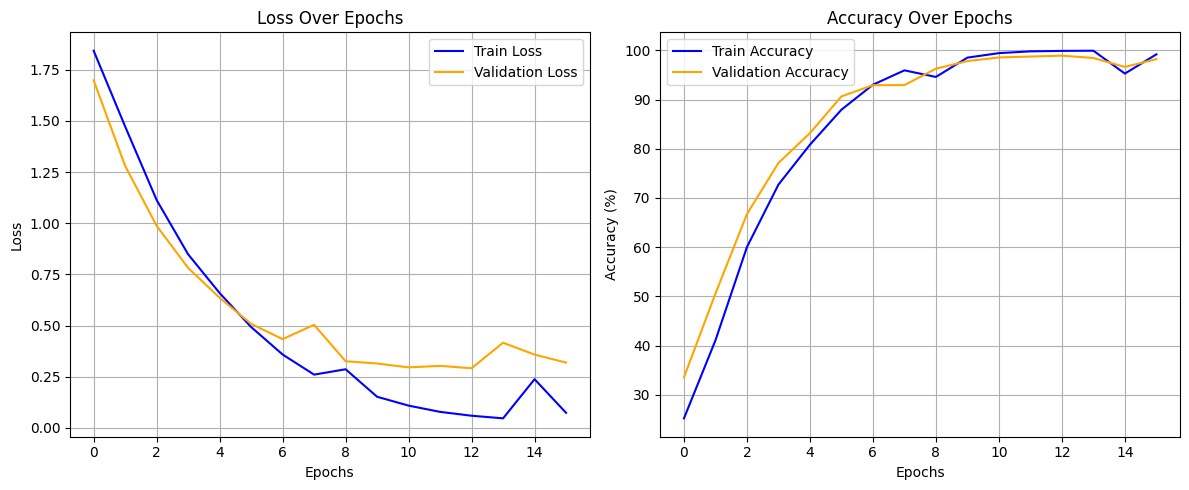

Training results saved to 'training_results.pkl'.


In [16]:
from torch.utils.data import DataLoader
from transformers import ViTFeatureExtractor
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import AdamW 
import torch.nn as nn
from PIL import Image
import numpy as np
from tqdm import tqdm  # Import tqdm for progress bar

# Initialize lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Load the feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

# Define the optimizer
optimizer = AdamW(model.parameters(), lr=3e-5, weight_decay=0.01)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1, min_lr=1e-7, verbose=True)

# Adjust the feature extractor to handle RGB images
feature_extractor = ViTFeatureExtractor(
    do_resize=False, 
    size=224, 
    do_rescale=False,  # Disable rescaling if your images are already in the [0, 1] range
    do_normalize=True, 
    image_mean=[0.485, 0.456, 0.406], 
    image_std=[0.229, 0.224, 0.225],  # Use 3-channel std for RGB
    resample=Image.BILINEAR
)

# Early Stopping Parameters
patience = 3  # Number of epochs to wait for improvement before stopping
best_val_loss = float('inf')
epochs_without_improvement = 0

num_epochs = 20

# Create a GradScaler for mixed precision
scaler = torch.cuda.amp.GradScaler()

# Updated training loop with early stopping and progress bar updates
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    train_progress_bar = tqdm(train_dataloader, desc=f"Training Epoch {epoch + 1}", leave=True)

    for batch_idx, batch in enumerate(train_progress_bar):
        images, labels = batch
        
        inputs = feature_extractor(images=images, return_tensors="pt").to(device)
        labels = labels.to(device)

        # Mixed precision context
        with torch.cuda.amp.autocast():
            # Forward pass
            outputs = model(**inputs)  # Get the outputs as a dictionary
            logits = outputs['logits']  # Extract logits
            attn = outputs['attentions']
            img_emb=outputs['imgemb']

            # Compute the loss
            loss = criterion(logits, labels)

        # Backward pass and optimization
        scaler.scale(loss).backward()  # Scale the loss for gradient scaling
        scaler.step(optimizer)  # Step the optimizer
        scaler.update()  # Update the scaler
        optimizer.zero_grad()  # Zero the gradients

        running_loss += loss.item()
        
        # Calculate accuracy
        preds = torch.sigmoid(logits)  # Apply sigmoid to get probabilities
        predicted_labels = (preds > 0.5).float()
        correct_predictions += (predicted_labels == labels).sum().item()
        total_samples += labels.numel()

        # Update the progress bar with current loss and accuracy
        accuracy = correct_predictions / total_samples * 100
        avg_loss = running_loss / (batch_idx + 1)
        train_progress_bar.set_postfix({"Loss": avg_loss, "Accuracy": f"{accuracy:.2f}%"})

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_samples = 0
    with torch.no_grad():
        for batch in val_dataloader:
            images, labels = batch

            inputs = feature_extractor(images=images, return_tensors="pt").to(device)
            labels = labels.to(device)

            with torch.cuda.amp.autocast():
                outputs = model(**inputs)  # Get the outputs as a dictionary
                logits = outputs['logits']  # Extract logits
                attn = outputs['attentions']  # Extract embeddings if needed
                img_emb=outputs['imgemb']
                loss = criterion(logits, labels)

            val_loss += loss.item()

            preds = torch.sigmoid(logits)
            predicted_labels = (preds > 0.5).float()
            correct_val_predictions += (predicted_labels == labels).sum().item()
            total_val_samples += labels.numel()

    avg_val_loss = val_loss / len(val_dataloader)
    val_accuracy = correct_val_predictions / total_val_samples * 100
    train_losses.append(avg_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(accuracy)
    val_accuracies.append(val_accuracy)
    scheduler.step(avg_val_loss)
    # Print validation metrics
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%, "
          f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # Early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        # Optionally, save the model checkpoint here
        # torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print("Early stopping triggered.")
            break

print("Training Complete")
import matplotlib.pyplot as plt
# Plot the metrics
plt.figure(figsize=(12, 5))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()
import pickle

# Save the lists to a file using pickle
data_to_save = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies,
}

with open('/kaggle/working/srvit_model_training_results.pkl', 'wb') as f:
    pickle.dump(data_to_save, f)

print("Training results saved to 'training_results.pkl'.")

In [1]:
import os
from IPython.display import FileLink

def create_download_link(directory=os.curdir, file_name='super_resolution_data.pkl'):
    # Change to the specified directory
    os.chdir(directory)
    
    # Check if the file exists
    if os.path.exists(file_name):
        # Create a download link
        return FileLink(file_name)
    else:
        return "File does not exist."

# Call the function
create_download_link()

/kaggle/working/super_resolution_data.pkl